### Project Work for the course "Reproducible and Interactive Data Science"

# Testing Asteroseismic Radii of Dwarf Stars with Gaia Parallaxes

In this notebook we derive the distances, and thereby [parallaxes](https://en.wikipedia.org/wiki/Stellar_parallax), of a sample of almost a hundred stars based on their radii obtained from asteroseismology.
By comparing these parallaxes to the ones measured by the [Gaia spacecraft](http://www.esa.int/Our_Activities/Space_Science/Gaia_overview), we test the accuracy of the asteroseismic radii.

## Contents
* [Seismic Parallaxes](#seis_plx)
    * [Stellar Data](#stel_data)
    * [Scaling Relation Parameters](#scal_par)
    * [Calculation of Parallaxes](#plx_calc)


* [Comparison with Gaia Parallaxes](#gaia_comp)
    * [Error Distributions](#err_dist)
    * [Absolute Differences](#abs_diff)
    * [Relative Differences](#rel_diff)


* [Correcting the Scaling Relations](#scal_corr)

## Seismic Parallaxes <a class="anchor" id="seis_plx"></a>

...

![Animation](http://owww.phys.au.dk/~chri983d/animations/echelle2.gif "Animated echelle diagram")

### Stellar Data <a class="anchor" id="stel_data"></a>

...

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [2]:
obs_names = ['ID', 'teff', 'teff_unc', 'feh', 'feh_unc', 'dnu', 'dnu_unc',
             'numax', 'numax_unc', 'angdiam', 'angdiam_unc']
mass_rad_names = ['ID', 'rad', 'rad_unc', 'mass', 'mass_unc', 'logg', 'logg_unc']
plx_names = ['ID', 'plx', 'plx_unc']

star_obs = pd.read_table('data/star_obs.txt', header=None, skiprows=10,
                         names=obs_names, index_col=0)
star_mr = pd.read_table('data/star_mass_rad.txt', header=None, skiprows=3,
                         names=mass_rad_names, index_col=0)
star_plx = pd.read_table('data/star_par.txt', header=None, skiprows=3,
                         names=plx_names, index_col=0)

print('Number of stars with asteroseismic parameters: ', len(star_mr))
print('Number of stars with Gaia parallaxes: ', len(star_plx))

Number of stars with asteroseismic parameters:  95
Number of stars with Gaia parallaxes:  86


In [3]:
# Combine the DataFrames while excluding the stars without Gaia parallaxes
sa = star_plx.join([star_obs, star_mr], how='inner')
n_star = len(sa)
# Add columns for every parameter which will be derived later
for new_name in ['rad_scal', 'rad_scal_unc', 'mass_scal', 'mass_scal_unc',
                 'plx_rad', 'plx_rad_unc', 'plx_scal', 'plx_scal_unc',
                 'dnu_scal', 'dnu_scal_unc', 'numax_scal', 'numax_scal_unc']:
    sa[new_name] = np.zeros(n_star)

# The DataFrame is converted into a NumPy "Records array" since we don't need
# the indices of the DataFrame. This makes it easier to work with the data values.
sa = sa.to_records();

### Scaling Relation Parameters <a class="anchor" id="scal_par"></a>

...

In [4]:
def scal_mr(dnu, numax, teff):
    # Constants
    dnusun = 135.1
    numaxsun = 3090.
    teffsun = 5777.

    mass = np.power(numax/numaxsun, 3) * np.power(dnu/dnusun, -4) * np.power(teff/teffsun, 3/2)
    rad = (numax/numaxsun) * np.power(dnu/dnusun, -2) * np.power(teff/teffsun, 1/2)

    return mass, rad

def scal_mr_unc(dnu, dnu_unc, numax, numax_unc, teff, teff_unc, n_MC=1000):
    n = len(dnu)
    mass_unc, rad_unc = np.zeros(n), np.zeros(n)
    
    for i in range(n):
        teff_synth = np.random.normal(teff[i], teff_unc[i], n_MC)
        dnu_synth = np.random.normal(dnu[i], dnu_unc[i], n_MC)
        numax_synth = np.random.normal(numax[i], numax_unc[i], n_MC)

        mass_synth, rad_synth = scal_mr(dnu_synth, numax_synth, teff_synth)
        mass_unc[i], rad_unc[i] = np.std(mass_synth), np.std(rad_synth)

    return mass_unc, rad_unc

In [5]:
sa.mass_scal, sa.rad_scal = scal_mr(sa.dnu, sa.numax, sa.teff)

sa.mass_scal_unc, sa.rad_scal_unc = scal_mr_unc(sa.dnu, sa.dnu_unc,
                                                sa.numax, sa.numax_unc,
                                                sa.teff, sa.teff_unc)

In [6]:
def scal_dn(mass, rad, teff):
    # Constants
    dnusun = 135.1
    numaxsun = 3090.
    teffsun = 5777.

    dnu = np.power(mass, 1/2) * np.power(rad, -3/2) * dnusun
    numax = mass * np.power(rad, -2) * np.power(teff / teffsun, -1/2) * numaxsun

    return dnu, numax

def scal_dn_unc(mass, mass_unc, rad, rad_unc, teff, teff_unc, n_MC=1000):
    n = len(mass)
    dnu_unc, numax_unc = np.zeros(n), np.zeros(n)

    for i in range(n):
        teff_synth = np.random.normal(teff[i], teff_unc[i], n_MC)
        mass_synth = np.random.normal(mass[i], mass_unc[i], n_MC)
        rad_synth = np.random.normal(rad[i], rad_unc[i], n_MC)

        dnu_synth, numax_synth = scal_dn(mass_synth, rad_synth, teff_synth)
        dnu_unc[i], numax_unc[i] = np.std(dnu_synth), np.std(numax_synth)

    return dnu_unc, numax_unc

In [7]:
sa.dnu_scal, sa.numax_scal = scal_dn(sa.mass, sa.rad, sa.teff)

sa.dnu_scal_unc, sa.numax_scal_unc = scal_dn_unc(sa.mass, sa.mass_unc,
                                                 sa.rad, sa.rad_unc,
                                                 sa.teff, sa.teff_unc)

### Calculation of Parallaxes <a class="anchor" id="plx_calc"></a>

...

In [8]:
def plx_ast(rad, angdiam):
    # Constants
    radsun = 6.95508e5
    pc_conv = 6.685e-6

    diam = 2 * rad * radsun
    plx = 1000 / (pc_conv * diam/angdiam)

    return plx

def plx_ast_unc(rad, rad_unc, angdiam, angdiam_unc, n_MC=1000):
    n = len(rad)
    plx_unc = np.zeros(n)
    
    for i in range(n):
        rad_synth = np.random.normal(rad[i], rad_unc[i], n_MC)
        angdiam_synth = np.random.normal(angdiam[i], angdiam_unc[i], n_MC)

        plx_synth = plx_ast(rad_synth, angdiam_synth)
        plx_unc[i] = np.std(plx_synth)

    return plx_unc

In [9]:
sa.plx_rad = plx_ast(sa.rad, sa.angdiam)
sa.plx_rad_unc = plx_ast_unc(sa.rad, sa.rad_unc, sa.angdiam, sa.angdiam_unc)

sa.plx_scal = plx_ast(sa.rad_scal, sa.angdiam)
sa.plx_scal_unc = plx_ast_unc(sa.rad_scal, sa.rad_scal_unc, sa.angdiam, sa.angdiam_unc)

## Comparison with Gaia Parallaxes <a class="anchor" id="gaia_comp"></a>

...

### Error Distributions <a class="anchor" id="err_dist"></a>

...

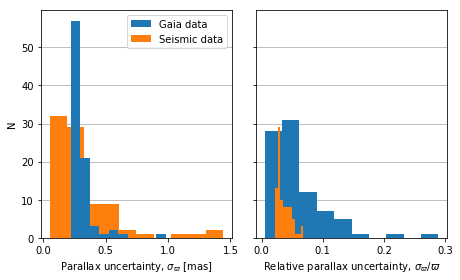

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6.5, 4.0))
ax1.hist(sa.plx_unc, alpha=1, label='Gaia data', zorder=3)
ax1.hist(sa.plx_rad_unc, alpha=1, label='Seismic data', zorder=2)
ax2.hist(sa.plx_unc/sa.plx, alpha=1, zorder=2)
ax2.hist(sa.plx_rad_unc/sa.plx_rad, alpha=1, zorder=3)

ax1.set_ylabel('N')
ax1.set_xlabel(r'Parallax uncertainty, $\sigma_{\varpi}$ [mas]')
ax2.set_xlabel(r'Relative parallax uncertainty, $\sigma_{\varpi} / \varpi$')
ax1.grid(axis='y', zorder=0)
ax2.grid(axis='y', zorder=0)
ax1.legend()

fig.tight_layout()
fig.savefig('figures/plx_hist.pdf')

### Absolute Differences <a class="anchor" id="abs_diff"></a>

In [11]:
def xy_diff(x, x_unc, y, y_unc):
    diff = x - y
    diff_unc = np.sqrt(x_unc**2 + y_unc**2)

    return diff, diff_unc

def xy_ratio(x, x_unc, y, y_unc):
    r = x / y
    r_unc = r * np.sqrt((x_unc / x)**2 + (y_unc / y)**2)

    return r, r_unc

def poly_fit(x, y, y_unc, xp_lim, order=1, n_boot=1000):
    px = np.linspace(xp_lim[0], xp_lim[1])
    pfit = np.polyfit(x, y, order, w=1/y_unc**2)
    poly = np.poly1d(pfit)
    py = poly(px)

    boot_results = np.zeros((n_boot, len(px)))
    for i in range(n_boot):
        rand_per = np.random.randint(len(x), size=len(x))
        synth_x = x[rand_per]
        synth_y = y[rand_per]
        synth_y_unc = y_unc[rand_per]

        pfit = np.polyfit(synth_x, synth_y, order, w=1/synth_y_unc**2)
        poly = np.poly1d(pfit)
        py_temp = poly(px)

        boot_results[i, :] = py_temp

    boot_lower = np.percentile(boot_results, 16, axis=0)
    boot_upper = np.percentile(boot_results, 84, axis=0)
    
    return px, py, boot_lower, boot_upper

In [12]:
def plot_plxdiff(plx, plx_unc, plx_ast, plx_ast_unc, ax, outliers=None, fit=False):
    plx_d, plx_d_unc = xy_diff(plx_ast, plx_ast_unc, plx, plx_unc)

    if outliers is not None:
        bf = np.isin(sa.ID, outliers)
        ax.errorbar(plx[~bf], plx_d[~bf], yerr=plx_d_unc[~bf], marker='o', ms=4,
                    mec='k', linestyle='none', capsize=0, lw=1)
        ax.errorbar(plx[bf], plx_d[bf], yerr=plx_d_unc[bf], marker='o', ms=4,
                    mec='k', linestyle='none', capsize=0, lw=1)
        ax.set_ylim([-2, 12])
    else:
        ax.errorbar(plx, plx_d, yerr=plx_d_unc, marker='o', ms=4,
                    mec='k', linestyle='none', capsize=0, lw=1)
        ax.set_ylim([-2, 3])

    if fit:
        px, py, py_low, py_high = poly_fit(plx, plx_d, plx_d_unc, [1., 100.])
        ax.plot(px, py, c='k', ls='--')
        ax.fill_between(px, py_low, py_high, alpha=0.3)

    ax.axhline(c='k', ls='--', lw=1)
    ax.set_xlim([1, 100])
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel(r'Gaia parallax, $\varpi_{\mathrm{Gaia}}$ [mas]')
    ax.set_ylabel(r'Diff, $\varpi_{\mathrm{Seismic}}-\varpi_{\mathrm{Gaia}}$ [mas]')

In [13]:
bad_ID = [8379927, 7510397, 10454113, 9025370, 1435467, 7940546, 12317678]

In [14]:
plt.rcParams.update({'xtick.top': True,
                     'ytick.right': True,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.minor.visible': True,
                     'ytick.minor.visible': True})

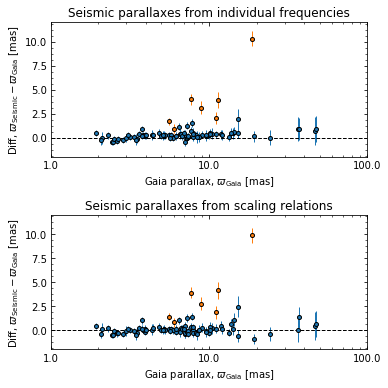

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 5.5))
plot_plxdiff(sa.plx, sa.plx_unc, sa.plx_rad, sa.plx_rad_unc, ax1, outliers=bad_ID)
plot_plxdiff(sa.plx, sa.plx_unc, sa.plx_scal, sa.plx_scal_unc, ax2, outliers=bad_ID)
ax1.set_title('Seismic parallaxes from individual frequencies')
ax2.set_title('Seismic parallaxes from scaling relations')
fig.tight_layout()
fig.savefig('figures/plxdiff_outliers.pdf')

In [16]:
saf = sa[~np.isin(sa.ID, bad_ID)]

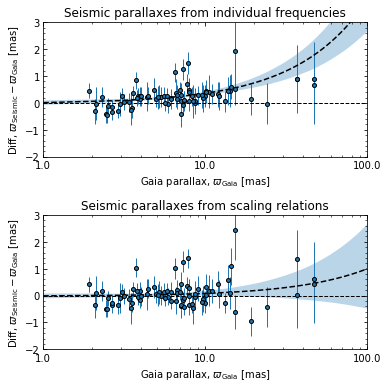

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 5.5))
plot_plxdiff(saf.plx, saf.plx_unc, saf.plx_rad, saf.plx_rad_unc, ax1, fit=True)
plot_plxdiff(saf.plx, saf.plx_unc, saf.plx_scal, saf.plx_scal_unc, ax2, fit=True)
ax1.set_title('Seismic parallaxes from individual frequencies')
ax2.set_title('Seismic parallaxes from scaling relations')
fig.tight_layout()
fig.savefig('figures/plxdiff_bootstrap.pdf')

In [18]:
def plot_plxdiff_int(gaia_offset=0.0, rad_factor=1.00, data='freqs'):
    plx = saf.plx + gaia_offset
    if data == 'freqs':
        rad = saf.rad * rad_factor
        rad_plx_unc = saf.plx_rad_unc
    elif data == 'scaling':
        rad = saf.rad_scal * rad_factor
        rad_plx_unc = saf.plx_scal_unc

    plx_rad = plx_ast(rad, saf.angdiam)

    fig, ax = plt.subplots()
    plot_plxdiff(plx, saf.plx_unc, plx_rad, rad_plx_unc, ax, fit=True)
    fig.tight_layout()

In [19]:
from ipywidgets import interactive
int_plot = interactive(plot_plxdiff_int, gaia_offset=(-0.3, 0.3, 0.02),
                                         rad_factor=(0.9, 1.1, 0.01),
                                         data=['freqs', 'scaling'])
int_plot

interactive(children=(FloatSlider(value=0.0, description='gaia_offset', max=0.3, min=-0.3, step=0.02), FloatSlider(value=1.0, description='rad_factor', max=1.1, min=0.9, step=0.01), Dropdown(description='data', options=('freqs', 'scaling'), value='freqs'), Output()), _dom_classes=('widget-interact',))

### Relative Differences <a class="anchor" id="rel_diff"></a>

...

In [20]:
def binned_ratios(bin_array, bins, r, r_unc):
    nbins = len(bins)-1
    inds = np.digitize(bin_array, bins, right=True)

    binx = np.zeros(nbins)
    bin_mean = np.zeros(nbins)
    bin_std = np.zeros(nbins)

    for i in range(nbins):
        where = np.where(inds == i+1)
        bin_r = r[where]
        bin_r_unc = r_unc[where]

        bin_mean[i] = np.sum(bin_r/bin_r_unc**2) / np.sum(1/bin_r_unc**2)
        bin_std[i] = np.sqrt(1/np.sum(1/bin_r_unc**2))

    return bin_mean, bin_std

In [21]:
def plot_plx_ratio(plx, plx_unc, plx_ast, plx_ast_unc, ax, xax='teff', errors=True,
                   plabel=None):
    plx_r, plx_r_unc = xy_ratio(plx_ast, plx_ast_unc, plx, plx_unc)
    if xax == 'teff':
        bin_array = saf.teff
        bins = np.arange(5300, 6800, 200, dtype=int)
        bin_centers = np.arange(5400, 6700, 200, dtype=int)
    elif xax == 'feh':
        bin_array = saf.feh
        bins = np.arange(-0.6, 0.45, 0.1)
        bin_centers = np.arange(-0.55, 0.4, 0.1)

    bin_mean, bin_std = binned_ratios(saf[xax], bins, plx_r, plx_r_unc)
    if errors:
        ax.errorbar(bin_centers, bin_mean, yerr=bin_std, marker='o',
                    c='k', linestyle='--', capsize=0, label=plabel)
    else:
        ax.plot(bin_centers, bin_mean, marker='o', c='k', mfc='none', linestyle=':',
                label=plabel)

def plot_plx_ratios(plx, plx_ast1, plx_ast2, ax, xax='teff',
                    ast_label1=None, ast_label2=None):
    plot_plx_ratio(*plx, *plx_ast1, ax, xax, errors=True, plabel=ast_label1)
    plot_plx_ratio(*plx, *plx_ast2, ax, xax, errors=False, plabel=ast_label2)
    ax.axhline(y=1, c='k', ls='--', lw=1)
    
    if xax == 'teff':
        ax.set_xlim([5300, 6800])
        ax.set_xlabel('Effective temperature [K]')
    elif xax == 'feh':
        ax.set_xlim([-0.6, 0.4])
        ax.set_xlabel('Metallicity [Fe/H]')
    
    ax.set_ylim([0.95, 1.12])
    ax.set_ylabel(r'Ratio, $\varpi_{\mathrm{Seismic}}$ / $\varpi_{\mathrm{Gaia}}$')
    if ast_label1 is not None or ast_label2 is not None:
        ax.legend(ncol=2)

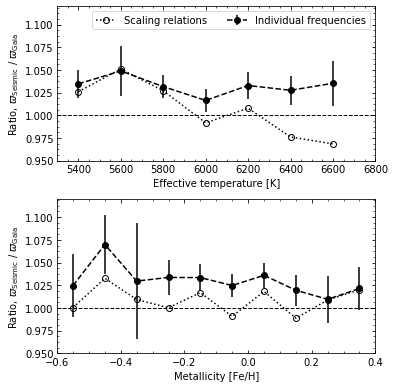

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 5.5))
plot_plx_ratios((saf.plx, saf.plx_unc), (saf.plx_rad, saf.plx_rad_unc),
                (saf.plx_scal, saf.plx_scal_unc), ax1, xax='teff',
                ast_label1='Individual frequencies', ast_label2='Scaling relations')
plot_plx_ratios((saf.plx, saf.plx_unc), (saf.plx_rad, saf.plx_rad_unc),
                (saf.plx_scal, saf.plx_scal_unc), ax2, xax='feh')

fig.tight_layout()
fig.savefig('figures/par_ratio.pdf')

In [23]:
def plot_plx_ratio_int(gaia_offset=0.0, rad_factor=1.00,
                       rad_scal_factor=1.00, angdiam_factor=1.00,
                       xax='teff', rfactor='const'):
    plx = saf.plx + gaia_offset
    if rfactor == 'const':
        rad = saf.rad * rad_factor
        rad_scal = saf.rad_scal * rad_scal_factor
    elif rfactor == 'lin_teff':
        rad = saf.rad * (1 + (rad_factor - 1)*(saf.teff - 5400)/1200)
        rad_scal = saf.rad_scal * (1 + (rad_scal_factor - 1)*(saf.teff - 5400)/1200)
    angdiam = saf.angdiam * angdiam_factor
    
    plx_rad = plx_ast(rad, angdiam)
    plx_scal = plx_ast(rad_scal, angdiam)
    
    fig, ax = plt.subplots()
    plot_plx_ratios((plx, saf.plx_unc), (plx_rad, saf.plx_rad_unc),
                    (plx_scal, saf.plx_scal_unc), ax, xax,
                    ast_label1='Individual frequencies', ast_label2='Scaling relations')
    fig.tight_layout()

In [24]:
int_plot2 = interactive(plot_plx_ratio_int, gaia_offset=(-0.3, 0.3, 0.02),
                                            rad_factor=(0.9, 1.1, 0.01),
                                            rad_scal_factor=(0.9, 1.1, 0.01),
                                            angdiam_factor=(0.9, 1.1, 0.01),
                                            xax=['teff', 'feh'],
                                            rfactor=['const', 'lin_teff'])
int_plot2

interactive(children=(FloatSlider(value=0.0, description='gaia_offset', max=0.3, min=-0.3, step=0.02), FloatSlider(value=1.0, description='rad_factor', max=1.1, min=0.9, step=0.01), FloatSlider(value=1.0, description='rad_scal_factor', max=1.1, min=0.9, step=0.01), FloatSlider(value=1.0, description='angdiam_factor', max=1.1, min=0.9, step=0.01), Dropdown(description='xax', options=('teff', 'feh'), value='teff'), Dropdown(description='rfactor', options=('const', 'lin_teff'), value='const'), Output()), _dom_classes=('widget-interact',))

## Correcting the Scaling Relations <a class="anchor" id="scal_corr"></a>

...

In [95]:
def plot_dm_ratio(teff, logg, dm, dm_unc, dm_scal, dm_scal_unc, ax, data='dnu'):
    if data == 'dnu':
        polyorder = 2
        ax.set_ylim([0.955, 1.025])
        ax.set_ylabel(r'$\Delta\nu_{\mathrm{obs}}$ / $\Delta\nu_{\mathrm{scaling}}$')
    elif data == 'numax':
        polyorder = 1
        ax.set_ylim([0.955, 1.085])
        ax.set_ylabel(r'$\nu_{\mathrm{max,obs}}$ / $\nu_{\mathrm{max,scaling}}$')
    r = xy_ratio(dm, dm_unc, dm_scal, dm_scal_unc)[0]
    r_unc = r*dm_unc/dm
    ax.errorbar(teff, r, yerr=r_unc, linestyle='none',
                c='k', capsize=0, lw=1, zorder=0)
    sc = ax.scatter(teff, r, s=30, c=logg, edgecolors='k',
                    cmap=plt.cm.get_cmap('afmhot'), zorder=1)
    px, py, py_low, py_high = poly_fit(teff, r, r_unc, [5420., 6780.], polyorder)
    ax.plot(px, py, c='k', ls='--')
    ax.fill_between(px, py_low, py_high, alpha=0.3)

    ax.set_xlim([5400, 6800])
    ax.axhline(y=1, c='k', ls='--', lw=1)
    ax.set_xlabel('Effective temperature [K]')
    
    return sc

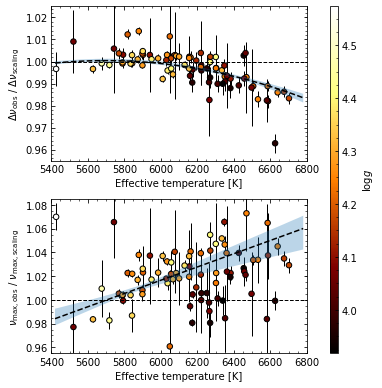

In [96]:
fig = plt.figure(figsize=(5.5, 5.5))
ax1 = plt.subplot2grid((2, 10), (0, 0), rowspan=1, colspan=9)
ax2 = plt.subplot2grid((2, 10), (1, 0), rowspan=1, colspan=9)
axcbar = plt.subplot2grid((2, 10), (0, 9), rowspan=2, colspan=1)
sc = plot_dm_ratio(sa.teff, sa.logg, sa.dnu, sa.dnu_unc, sa.dnu_scal, sa.dnu_scal_unc,
                   ax1, data='dnu')
plot_dm_ratio(sa.teff, sa.logg, sa.numax, sa.numax_unc, sa.numax_scal, sa.numax_scal_unc,
              ax2, data='numax')
fig.colorbar(sc, cax=axcbar, label=r'$\log g$')

fig.tight_layout()
fig.savefig('figures/scal_ratio.pdf')